In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from tqdm import trange
import os

new_width, new_height = 3.75, 3.0
plt.rcParams.update({
    "figure.figsize": (new_width, new_height),
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "font.family": "serif",
    "axes.linewidth": 1.3,
    "xtick.major.width": 1.3,
    "ytick.major.width": 1.3,
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "axes.labelpad": 8,
    "xtick.major.pad": 5,
    "ytick.major.pad": 5,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "savefig.dpi": 300,
    "savefig.format": "pdf",
    "savefig.bbox": "tight"
})

def finalize_plot(filename):
    """Save and show a high-quality PDF plot."""
    plt.tight_layout()
    plt.savefig(f"{filename}.pdf")
    plt.show()

# --- Data Download and Load ---
file_id = '1F6b961eijthkGNWuA217IqlzwHM9k_4a'
url = f'https://drive.google.com/uc?id={file_id}'
file_path = 'data.csv'
if not os.path.exists(file_path):
    gdown.download(url, file_path, quiet=False)

df = pd.read_csv(file_path)

data = df[['userId', 'movieId', 'rating']].values
_, u_map = np.unique(data[:, 0], return_inverse=True)
_, m_map = np.unique(data[:, 1], return_inverse=True)
data[:, 0], data[:, 1] = u_map.astype(int), m_map.astype(int)

def create_index(data, col):
    """
    Grouping rows by unique values in the specified column.
    Returns a list of np.ndarrays, one per unique group.
    """
    sorted_data = data[data[:, col].argsort()]
    boundaries = np.where(np.diff(sorted_data[:, col]) != 0)[0] + 1
    return np.split(sorted_data, boundaries)

user_index = create_index(data, 0)
movie_index = create_index(data, 1)

print(f"✅ Indexed dataset with {len(user_index)} users and {len(movie_index)} movies.")


✅ Indexed dataset with 200948 users and 84432 movies.


In [2]:
# --- 1. Train/Test Split ---
np.random.seed(42)
train_l, test_l = [], []
for u_r in user_index:
    shuf = np.random.permutation(len(u_r))
    split = max(1, int(0.2 * len(u_r)))
    test_l.append(u_r[shuf[:split]])
    train_l.append(u_r[shuf[split:]])

train_data = np.vstack(train_l)
test_data = np.vstack(test_l)
train_by_movie = create_index(train_data, 1)
global_mean = np.mean(train_data[:, 2])

# --- 2. Parameters ---
K, lambda_reg, iters = 10, 0.1, 20
n_users, n_movies = len(user_index), len(movie_index)
u_biases = np.zeros(n_users)
m_biases = np.zeros(n_movies)
U = np.random.normal(0, 0.1, (n_users, K))
V = np.random.normal(0, 0.1, (n_movies, K))
I_K = lambda_reg * np.eye(K)

# --- 3. Metrics Functions ---
def get_rmse(d, ub, mb, U, V, mu):
    u_idx, m_idx = d[:, 0].astype(int), d[:, 1].astype(int)
    interaction = np.sum(U[u_idx] * V[m_idx], axis=1)
    preds = np.clip(mu + ub[u_idx] + mb[m_idx] + interaction, 0.5, 5.0)
    return np.sqrt(np.mean((d[:, 2] - preds) ** 2))

def compute_loss(data_subset, ub, mb, U, V, mu, l_reg):
    u_idx, m_idx = data_subset[:, 0].astype(int), data_subset[:, 1].astype(int)
    ratings = data_subset[:, 2]
    interaction = np.sum(U[u_idx] * V[m_idx], axis=1)
    preds = np.clip(mu + ub[u_idx] + mb[m_idx] + interaction, 0.5, 5.0)
    squared_error = np.sum((ratings - preds) ** 2)
    regularization = l_reg * (np.sum(U**2) + np.sum(V**2) + np.sum(ub**2) + np.sum(mb**2))
    return squared_error + regularization

# --- 4. ALS Optimization Loop ---
t_err, v_err, t_loss, v_loss = [], [], [], []

for i in trange(iters, desc="Training Iterations"):
    # --- Update User Biases and Latents ---
    for u_r in train_l:
        u = int(u_r[0, 0])
        m_idx = u_r[:, 1].astype(int)
        r = u_r[:, 2]
        interaction = np.sum(U[u] * V[m_idx], axis=1)
        u_biases[u] = np.sum(r - global_mean - m_biases[m_idx] - interaction) / (len(u_r) + lambda_reg)
        y_u = r - (global_mean + u_biases[u] + m_biases[m_idx])
        U[u] = np.linalg.solve(V[m_idx].T @ V[m_idx] + I_K, V[m_idx].T @ y_u)

    # --- Update Movie Biases and Latents ---
    for m_r in train_by_movie:
        m = int(m_r[0, 1])
        u_idx = m_r[:, 0].astype(int)
        r = m_r[:, 2]
        interaction = np.sum(V[m] * U[u_idx], axis=1)
        m_biases[m] = np.sum(r - global_mean - u_biases[u_idx] - interaction) / (len(m_r) + lambda_reg)
        y_m = r - (global_mean + u_biases[u_idx] + m_biases[m])
        V[m] = np.linalg.solve(U[u_idx].T @ U[u_idx] + I_K, U[u_idx].T @ y_m)

    # --- Metrics ---
    t_err.append(get_rmse(train_data, u_biases, m_biases, U, V, global_mean))
    v_err.append(get_rmse(test_data, u_biases, m_biases, U, V, global_mean))
    t_loss.append(compute_loss(train_data, u_biases, m_biases, U, V, global_mean, lambda_reg))
    v_loss.append(compute_loss(test_data, u_biases, m_biases, U, V, global_mean, lambda_reg))

    print(f"Iter {i+1:2d} | Train RMSE: {t_err[-1]:.4f} | Test RMSE: {v_err[-1]:.4f} | Train Loss: {t_loss[-1]:.2e}")


Training Iterations:   5%|▌         | 1/20 [00:53<16:56, 53.49s/it]

Iter  1 | Train RMSE: 0.8173 | Test RMSE: 0.9011 | Train Loss: 1.74e+07


Training Iterations:  10%|█         | 2/20 [01:43<15:27, 51.53s/it]

Iter  2 | Train RMSE: 0.7673 | Test RMSE: 0.8616 | Train Loss: 1.54e+07


Training Iterations:  15%|█▌        | 3/20 [02:34<14:31, 51.25s/it]

Iter  3 | Train RMSE: 0.7401 | Test RMSE: 0.8363 | Train Loss: 1.43e+07


Training Iterations:  20%|██        | 4/20 [03:25<13:36, 51.05s/it]

Iter  4 | Train RMSE: 0.7250 | Test RMSE: 0.8218 | Train Loss: 1.37e+07


Training Iterations:  25%|██▌       | 5/20 [04:16<12:44, 50.96s/it]

Iter  5 | Train RMSE: 0.7161 | Test RMSE: 0.8130 | Train Loss: 1.34e+07


Training Iterations:  30%|███       | 6/20 [05:05<11:48, 50.58s/it]

Iter  6 | Train RMSE: 0.7106 | Test RMSE: 0.8074 | Train Loss: 1.32e+07


Training Iterations:  35%|███▌      | 7/20 [05:57<11:00, 50.83s/it]

Iter  7 | Train RMSE: 0.7069 | Test RMSE: 0.8037 | Train Loss: 1.30e+07


Training Iterations:  40%|████      | 8/20 [06:48<10:11, 50.94s/it]

Iter  8 | Train RMSE: 0.7043 | Test RMSE: 0.8010 | Train Loss: 1.29e+07


Training Iterations:  45%|████▌     | 9/20 [07:40<09:24, 51.30s/it]

Iter  9 | Train RMSE: 0.7023 | Test RMSE: 0.7991 | Train Loss: 1.29e+07


Training Iterations:  50%|█████     | 10/20 [08:36<08:48, 52.88s/it]

Iter 10 | Train RMSE: 0.7008 | Test RMSE: 0.7976 | Train Loss: 1.28e+07


Training Iterations:  55%|█████▌    | 11/20 [09:29<07:54, 52.71s/it]

Iter 11 | Train RMSE: 0.6996 | Test RMSE: 0.7965 | Train Loss: 1.28e+07


Training Iterations:  60%|██████    | 12/20 [10:22<07:02, 52.78s/it]

Iter 12 | Train RMSE: 0.6987 | Test RMSE: 0.7956 | Train Loss: 1.27e+07


Training Iterations:  65%|██████▌   | 13/20 [11:13<06:05, 52.21s/it]

Iter 13 | Train RMSE: 0.6979 | Test RMSE: 0.7948 | Train Loss: 1.27e+07


Training Iterations:  70%|███████   | 14/20 [12:04<05:11, 51.84s/it]

Iter 14 | Train RMSE: 0.6973 | Test RMSE: 0.7942 | Train Loss: 1.27e+07


Training Iterations:  75%|███████▌  | 15/20 [12:55<04:17, 51.60s/it]

Iter 15 | Train RMSE: 0.6967 | Test RMSE: 0.7937 | Train Loss: 1.26e+07


Training Iterations:  80%|████████  | 16/20 [13:46<03:26, 51.60s/it]

Iter 16 | Train RMSE: 0.6962 | Test RMSE: 0.7933 | Train Loss: 1.26e+07


Training Iterations:  85%|████████▌ | 17/20 [14:37<02:34, 51.41s/it]

Iter 17 | Train RMSE: 0.6957 | Test RMSE: 0.7929 | Train Loss: 1.26e+07


Training Iterations:  90%|█████████ | 18/20 [15:28<01:42, 51.09s/it]

Iter 18 | Train RMSE: 0.6953 | Test RMSE: 0.7926 | Train Loss: 1.26e+07


Training Iterations:  95%|█████████▌| 19/20 [16:19<00:51, 51.24s/it]

Iter 19 | Train RMSE: 0.6950 | Test RMSE: 0.7923 | Train Loss: 1.26e+07


Training Iterations: 100%|██████████| 20/20 [17:10<00:00, 51.53s/it]

Iter 20 | Train RMSE: 0.6946 | Test RMSE: 0.7920 | Train Loss: 1.25e+07


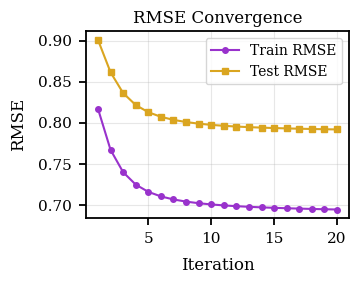

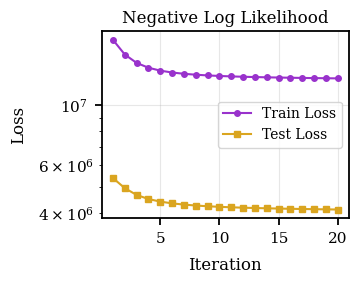


Top 10 Recommendations for a Toy Story Fan:
Movie ID: 202191
Movie ID: 83569
Movie ID: 218211
Movie ID: 144984
Movie ID: 175407
Movie ID: 26968
Movie ID: 154933
Movie ID: 181853
Movie ID: 128582
Movie ID: 142837


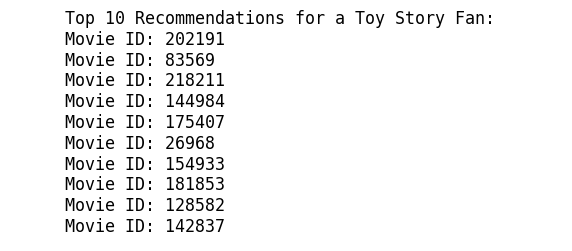

In [3]:
# --- 1. RMSE Convergence Plot ---
fig, ax = plt.subplots()
ax.plot(range(1, iters + 1), t_err, marker='o', color='#9932CC', label="Train RMSE", markersize=4)
ax.plot(range(1, iters + 1), v_err, marker='s', color='#DAA520', label="Test RMSE", markersize=4)
ax.set_title("RMSE Convergence")
ax.set_xlabel("Iteration")
ax.set_ylabel("RMSE")
ax.legend(prop={'size': 10})
finalize_plot("practical_3_rmse")

# --- 2. Loss Convergence Plot (Log Scale) ---
fig, ax = plt.subplots()
ax.plot(range(1, iters + 1), t_loss, marker='o', color='#9932CC', label="Train Loss", markersize=4)
ax.plot(range(1, iters + 1), v_loss, marker='s', color='#DAA520', label="Test Loss", markersize=4)
ax.set_title("Negative Log Likelihood")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_yscale('log')
ax.legend(prop={'size': 10})
finalize_plot("practical_3_loss")

# --- 3. Personalization Example: Toy Story Fan ---
target_movie_id = 1
movie_ids_sorted = np.unique(df['movieId'].values)
toy_story_idx = np.where(movie_ids_sorted == target_movie_id)[0][0]

dummy_ratings = [(toy_story_idx, 5.0)]
A_d, b_d = np.zeros((K, K)), np.zeros(K)
for m_idx, r in dummy_ratings:
    v_i = V[m_idx]
    A_d += np.outer(v_i, v_i)
    b_d += (r - global_mean - m_biases[m_idx]) * v_i

d_vec = np.linalg.solve(A_d + lambda_reg * np.eye(K), b_d)
scores = np.dot(d_vec, V.T) + 0.05 * m_biases

# --- 4. Top 5 Recommendations ---
top_10 = np.argsort(scores)[-10:][::-1]
recommended_movie_ids = movie_ids_sorted[top_10]
recommendation_text = "Top 10 Recommendations for a Toy Story Fan:\n" + "\n".join(f"Movie ID: {mid}" for mid in recommended_movie_ids)

print("\n" + recommendation_text)
plt.figure(figsize=(6, 2))
plt.text(0.1, 0.5, recommendation_text, fontsize=12, family='monospace')
plt.axis('off')
finalize_plot("results")
